
| dataframe      | Description |due|
| ----------- | ----------- |----------- |
| tomato   |토마토 가격/거래량 + 부산 날씨   +  소비자 물가지수 + 유가     |20190101 ~ 20200928|
| grape   | 캠벨얼리 가격/거래량 + 남원 날씨   +  소비자 물가지수 + 유가    |20190101 ~ 20200928|
| shinemuscat   |샤인마스캇  가격/거래량 + 구미 날씨   +  소비자 물가지수 + 유가          |20190101 ~ 20200928|
| train   |   tomato +  grape +  shinemuscat   | 20190101 ~ 20200928|
| test   |   tomato +  grape +  shinemuscat   | 20200929 ~ 20200928|
| df     | train + test       | 20190101 ~ 20201105|

# 샤인머스캇 예시

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import tensorflow as tf
# import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

/var/folders/lm/z4n_2b8s6rj3_vv57sg789kc0000gn/T/ipykernel_18728/2800944291.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
raw_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/processed/'

In [3]:
tomato = pd.read_csv(processed_path+'tomato.csv')
grape = pd.read_csv(processed_path+'grape.csv')
shinemuscat = pd.read_csv(processed_path+'shinemuscat.csv')

train = pd.read_csv(raw_path+'train.csv')
test = pd.read_csv(raw_path+'test.csv')
private = pd.read_csv(raw_path+'private_data.csv')
submission = pd.read_csv(raw_path+'sample_submission.csv')


print(train.shape)
print(test.shape)
print(private.shape)
print(submission.shape)

(1733, 44)
(37, 44)
(291, 44)
(228, 22)


In [4]:
tomato.drop(columns=[ '고급휘발유', '보통휘발유', '실내등유' ], inplace=True )
grape.drop(columns=[ '고급휘발유',  '보통휘발유', '실내등유' ], inplace=True )
shinemuscat.drop(columns=[ '고급휘발유', '보통휘발유','실내등유' ], inplace=True )

## 정규화

In [5]:
robust_shinemuscat = shinemuscat[['샤인마스캇_거래량(kg)','소비자물가지수', '자동차용경유',
       '평균기온', '최고기온', '최저기온', '평균운량', '일강수량', '일교차']]

In [6]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
robust_scaler = robust_scaler.fit_transform(robust_shinemuscat)
shinemuscat_scaler = pd.DataFrame(robust_scaler, columns=robust_shinemuscat.columns)
shinemuscat_scaler

,샤인마스캇_거래량(kg),소비자물가지수,자동차용경유,평균기온,최고기온,최저기온,평균운량,일강수량,일교차
0,-0.045291,-1.704941,-0.741484,-0.864706,-0.794118,-0.841808,0.00,0.0,0.470588
1,-0.045291,-1.704941,-0.747138,-0.764706,-0.635294,-0.723164,0.00,0.0,0.588235
2,-0.045291,-1.704941,-0.752862,-0.682353,-0.470588,-0.689266,0.00,0.0,1.019608
3,-0.045291,-1.704941,-0.761696,-0.517647,-0.594118,-0.406780,0.00,0.0,-0.372549
4,-0.045291,-1.704941,-0.774700,-0.788235,-0.952941,-0.593220,0.00,0.0,-0.921569
...,...,...,...,...,...,...,...,...,...
1728,101.750863,0.887059,-1.036396,0.229412,0.141176,0.310734,1.36,0.0,-0.411765
1729,109.149389,0.887059,-1.041696,0.252941,0.282353,0.293785,1.20,0.0,0.117647
1730,112.569986,0.887059,-1.046572,0.164706,0.229412,0.203390,1.12,0.0,0.254902
1731,3.453630,0.887059,-1.048763,0.182353,0.217647,0.225989,0.42,0.0,0.137255


## 모델링
성능을 알아보기 위한 모델 <br> 샤인머스캇 가격을 예측

In [7]:
# 2020년08월31일까지 train, 2020년09월01일부터 test

split = 28
target = shinemuscat['샤인마스캇_가격(원/kg)']

X_train = shinemuscat_scaler[:-split]
y_train = target[:-split]
X_test = shinemuscat_scaler[-split:]
y_test = target[-split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1705, 9) (1705,) (28, 9) (28,)


### 모델의 예측 결과
전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

[모델링참고](https://github.com/seongmoonKang/Data-Analysis-Capstone)

###  RandomForest

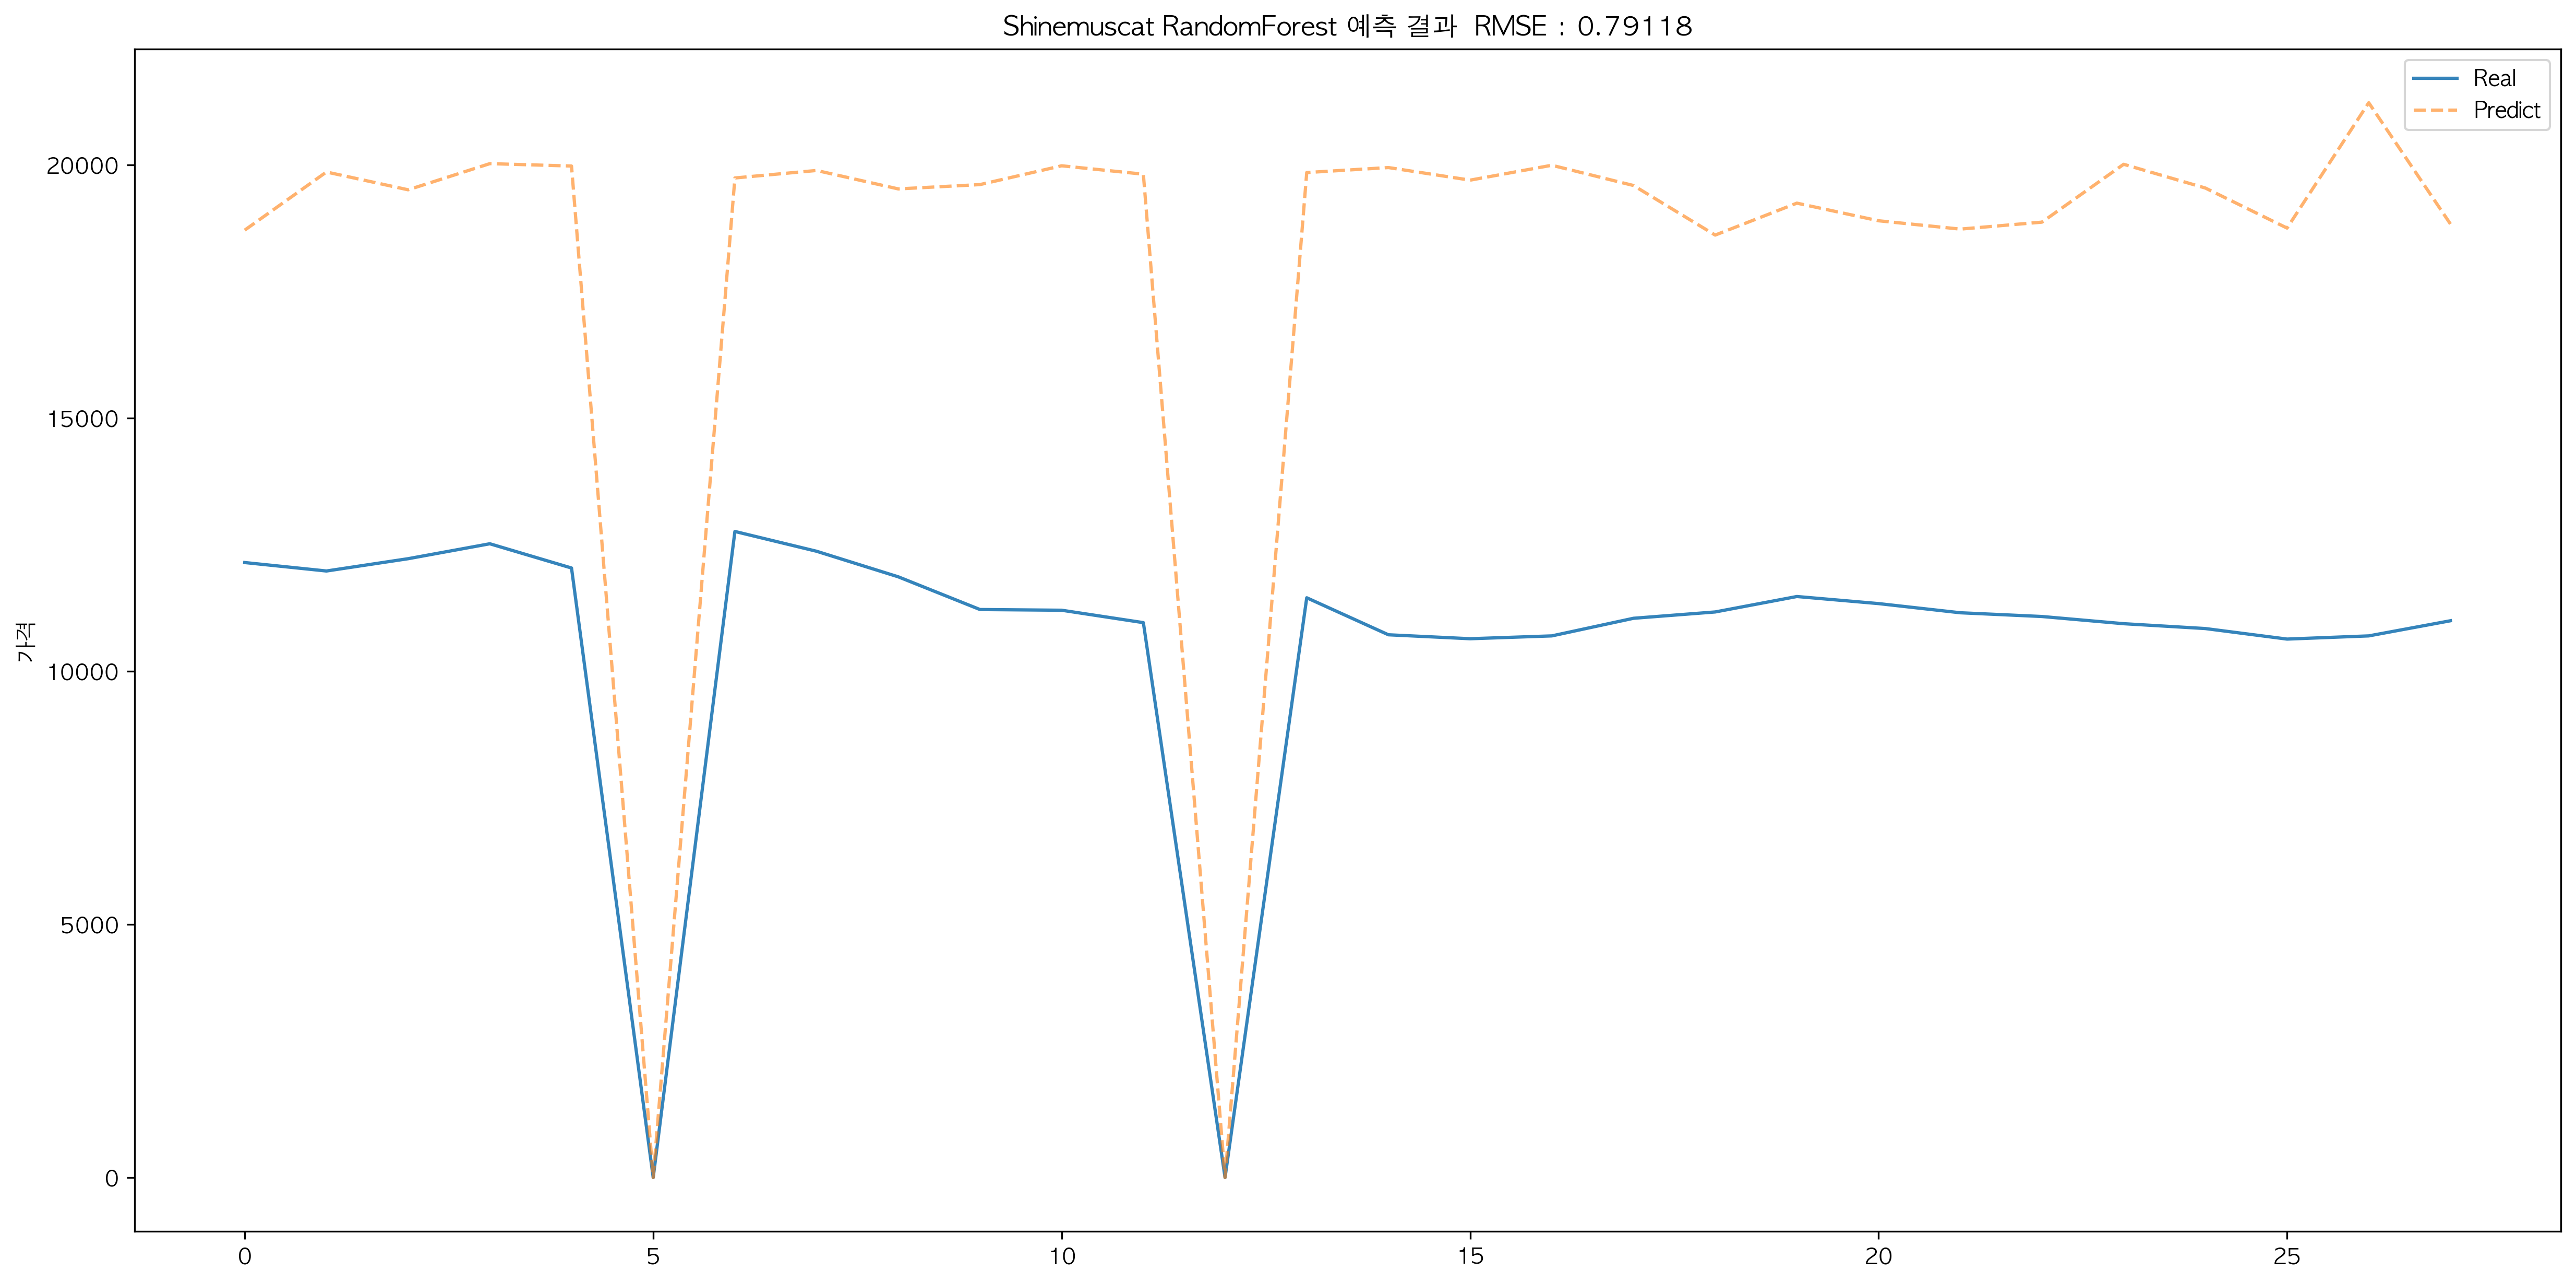

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import seaborn as sns

model = RandomForestRegressor()
model.fit(X_train, y_train)

# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)/10000

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat RandomForest 예측 결과'+ '  RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_test), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_test), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

### LSTM

### LightGBM

In [9]:
def init_score(y):
    return y - np.mean(y)

In [10]:
train_set = lgb.Dataset(data = X_train,  label = init_score(y_train), free_raw_data=False)
test_set = lgb.Dataset(data = X_test,  label = init_score(y_test),free_raw_data=False)

In [21]:
params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'seed':42,
          'num_threads':8
             }

model = lgb.train(params, 
                   train_set,
                   10000,
                   test_set,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 9
[LightGBM] [Info] Start training from score 0.000012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

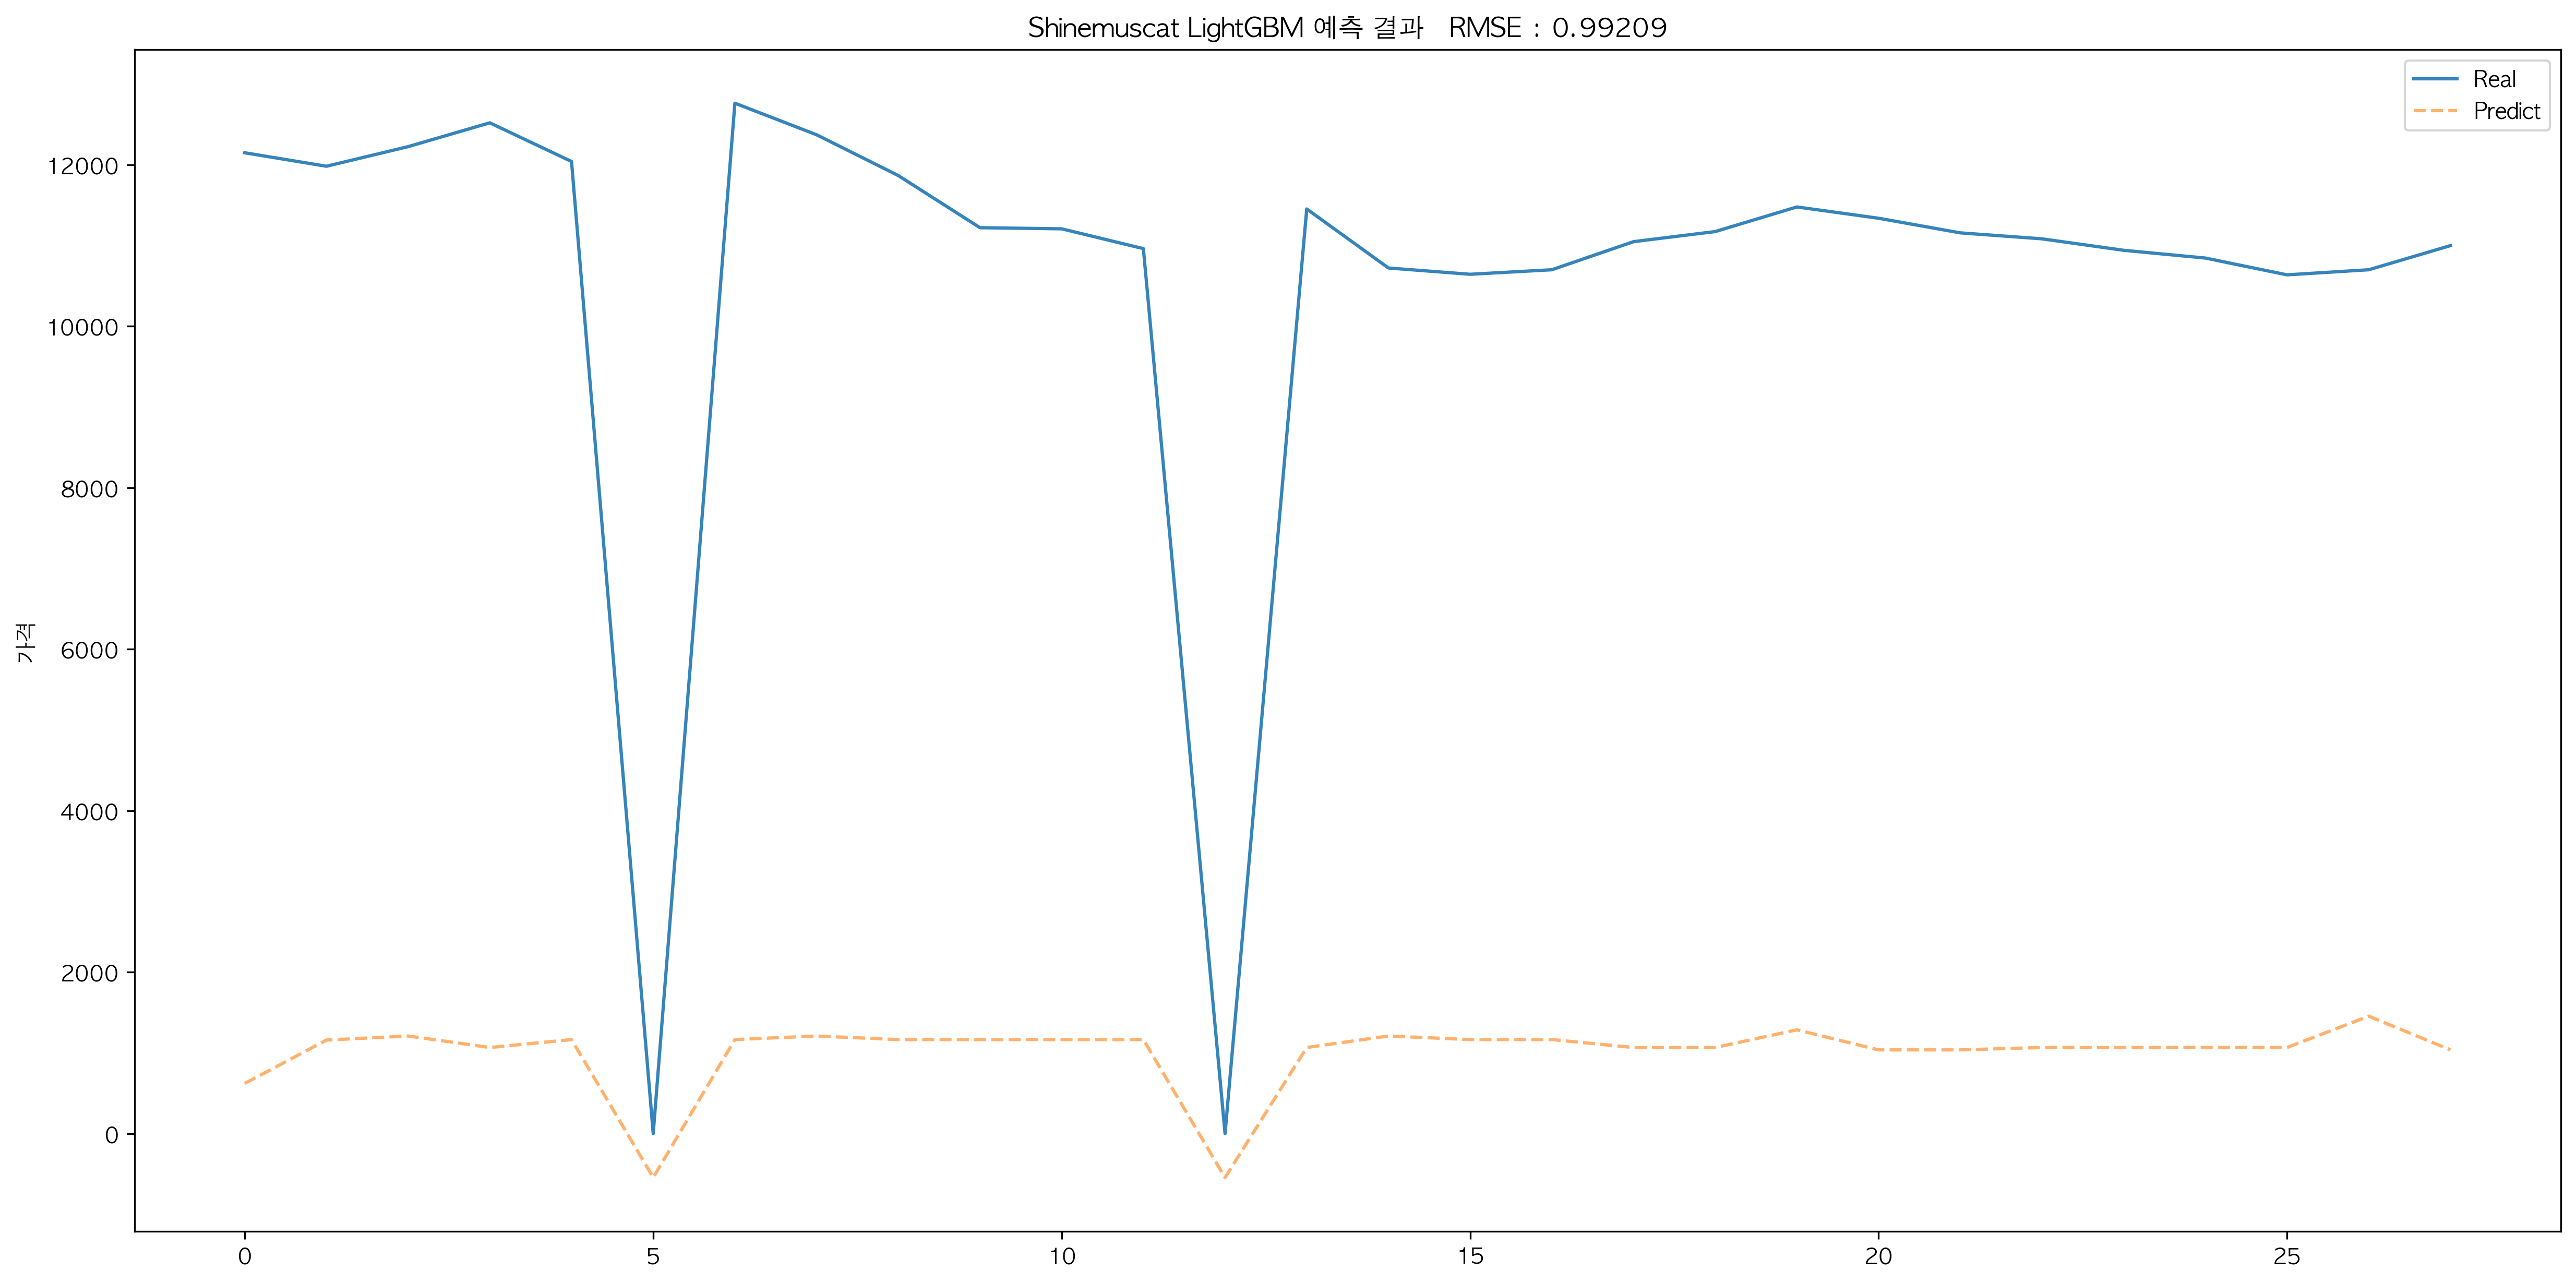

In [22]:
# metrics
y_pred = model.predict(X_test)
RMSE =  (mean_squared_error(y_test, y_pred) ** 0.5)/10000
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_test), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_test), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

### XGBoost